# День 02 – Предиктивный анализ I

Наконец-то вы подошли уже вплотную к задаче, которая вам была поставлена ранее – разобраться с оттоком клиентов в банке, научившись его прогнозировать. Сегодня вы построите свою первую модель машинного обучения и построите прогноз по клиентам.

## 0. Импорт библиотек

В этот раз их тоже будет немало. К знакомым вам в этом блоке появляется библиотека seaborn, которая позволяет строить более красивые и сложные визуализации. Они нам потребуются.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
sns.set_style("darkgrid") #у графиков будет красивая серая подложка

Также с этого дня вы начнете работать с библиотекой `scikit-learn`, в которой как раз много удобных функций и методов для машинного обучения и предобработки данных. Но ее мы будем добавлять точечно по ходу процесса анализа данных для большей наглядности. 

## 1. Загрузка данных

Сегодня наконец-то начнем работать с готовым датасетом без пропущенных значений, с новыми столбцами, которые созданы путем группировки непрерывных признаков.

In [ ]:
df = pd.read_csv('путь к файлу')

## 2. Демонстрация логистической регрессии

Прежде, чем вы начнете работать с датасетом и мы поделимся еще парой полезных команд, хочется продемонстрировать принцип работы логистической регрессии – одного из базовых алгоритмов машинного обучения.

Сделаем это на другом датасете, который больше подходит для целей демонстрации. Это датасет вин. Есть вина, произведенные на трех разных виноградниках. Нужно научиться определять какое вино относится к какому винограднику. Нашу задачу сократим для удобства до двух виноградников и только двух признаков: процент алкоголя и уровень пролина (аминокислота, входящая в состав вин).

In [2]:
from sklearn.datasets import load_wine

In [3]:
data = load_wine()
wine_df = pd.DataFrame(data.data, columns=data.feature_names)
wine_df.insert(13, 'CLASS', data.target)
wine_two_classes = wine_df.loc[(wine_df.CLASS == 0) | (wine_df.CLASS == 1)]
wine_ready = wine_two_classes[['alcohol', 'proline', 'CLASS']]

In [4]:
wine_ready.head(2)

,alcohol,proline,CLASS
0,14.23,1065.0,0
1,13.20,1050.0,0


Визуализируем распределение вин по уровню алкоголя и пролина при помощи диаграммы рассеяния и расскрасим точки в соответствии с виноградниками.

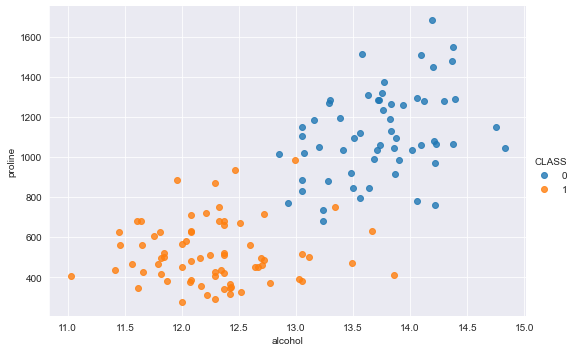

In [ ]:
sns.lmplot(x="alcohol", y="proline", data=wine_ready, fit_reg=False, hue='CLASS', legend=True,
          height=5, aspect=1.5)

Кажется, невооруженным взглядом видно, что виноградники производят отличающиеся группы вин. И можно придумать какое-то правило (или границу), по которой можно было провести отсечение: что вот всё, что тут, мы будем считать произведенным на первом винограднике, а всё, что там, мы будем считать – на втором винограднике.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X = wine_ready[['alcohol', 'proline']]
y = wine_ready['CLASS']

In [ ]:
clf = LogisticRegression(random_state=21).fit(X, y) #обучим модель

In [ ]:
clf.coef_ #посмотрим на коэффициенты при получившейся регрессии

array([[-2.07000729, -0.01197466]])

Один коэффициент получился большим, а второй маленьким. Разница в 200 раз. Это может быть не очень хорошо. Проблема в том, что изначально наши признаки находились в разных шкалах по размеру. Лучше их привести в какую-то одну общую размерность.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
X2 = scaler.fit_transform(X) #сделаем стандартизацию наших признаков

In [ ]:
X2[:5]

array([[ 1.452455  ,  0.782868  ],
       [ 0.28906609,  0.74015178],
       [ 0.24388594,  1.12459784],
       [ 1.61058554,  1.96468369],
       [ 0.33424624, -0.15688904]])

Как видно, признаки теперь у нас находятся примерно в одной какой-то шкале. Лог. регрессии будет теперь проще подобрать коэффициенты, которые при этом будут тоже примерно находится в одной размерности.

In [ ]:
clf2 = LogisticRegression(random_state=21).fit(X2, y)

In [ ]:
clf2.coef_

array([[-2.09192663, -2.4554651 ]])

Сейчас будет много кода для того, чтобы построить красивый график. Этот кусок кода вам в самостоятельной части не понадобится, поэтому можно на нем сильно не заострять внимание.

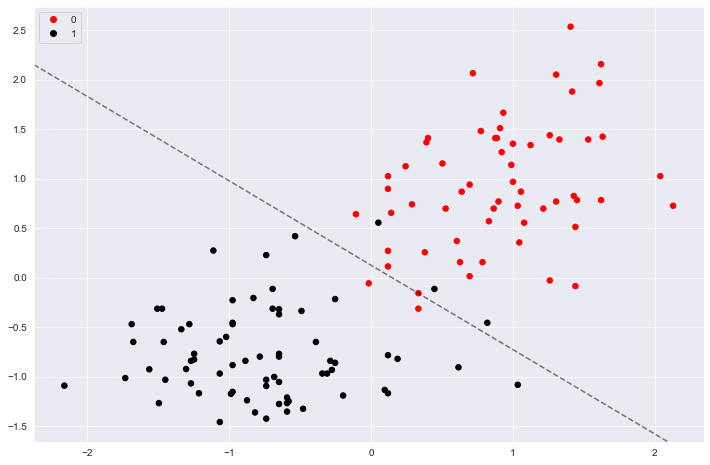

In [ ]:
plt.figure(figsize=(12,8))
a = plt.scatter(X2[:, 0], X2[:, 1], c=y, s=30, cmap='flag')

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf2.decision_function(xy).reshape(XX.shape)
# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.5,
           linestyles=['--', '-', '--'])
plt.legend(handles=a.legend_elements()[0], labels=['0', '1'], loc='upper left')

Что сделала лог. регрессия? По сути в геометрическом смысле она предложила провести прямую линию, которая наилучшим образом отсекает точки двух классов. Всё, что ниже и левее этой линии считаем черными точками, а то, что правее и выше – красными. Да, правило неидеальное – местами есть ошибки: какие-то черные точки мы считаем красными, и наоборот. Но в общем и целом модель неплохо справилась с этим.

Давайте попробуем померить качество модели в каком-то числовом виде, а не только взглядом на график. Есть метрика `accuracy`, которая показывает % случаев, в которых модель верно угадала класс, по отношению к общему количеству наблюдений.

In [ ]:
clf2.score(X2, y) * 100

96.15384615384616

В 96% случаев модель справилась с предсказанием хорошо. Эта метрика может быть обманчивой, если у вас классы несбалансированы. Например, у вас и так 95% наблюдений – это один и тот же класс. Модель может просто все точки покрасить в один цвет сразу и получить высокий уровень качества, но на самом деле она справилась недостаточно хорошо. Про более сложные метрики поговорим завтра. Пока достаточно и этой.

## 3. Полезные команды

1. Сделать **one-hot encoding** для категориальных признаков.

In [ ]:
pd.get_dummies(df.APP_EDUCATION)

,a,ac,av,e,h,hh,hi,i,s,ss,uh,us,неизвестна
0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355185,0,0,0,0,0,0,0,0,0,0,0,0,1
355186,0,0,0,0,0,0,0,0,0,0,0,0,1
355187,0,0,0,0,0,0,0,0,0,0,0,0,1
355188,0,0,0,0,0,0,0,0,0,0,0,0,1


2. **Разбить датасет** на train и test.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(wine_ready[['alcohol', 'proline']], wine_ready.CLASS, 
                                                    test_size=0.2, random_state=21)

In [ ]:
X_train.head(2)

,alcohol,proline
87,11.65,562.0
55,13.56,1120.0


In [ ]:
X_test.head(2)

,alcohol,proline
19,13.64,845.0
42,13.88,1095.0


In [ ]:
y_train.head(2)

87    1
55    0
Name: CLASS, dtype: int64

In [ ]:
y_test.head(2)

19    0
42    0
Name: CLASS, dtype: int64

3. Функция, чтобы посмотреть на графике, **какие признаки** модель считает **наиболее важными** (у кого из них больше по модулю коэффициенты).

In [ ]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)
    plt.figure(figsize=(12,5))
    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

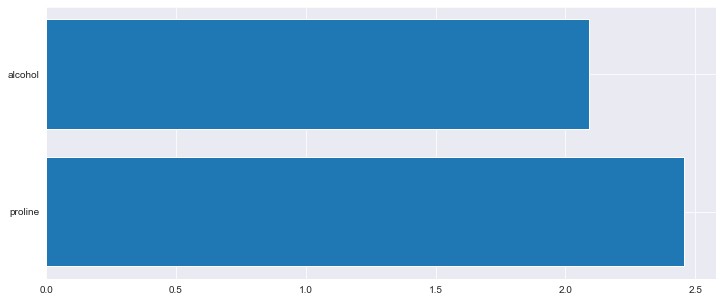

In [ ]:
f_importances(abs(clf2.coef_[0]), X_train.columns, top=2)

## 4. Самостоятельная часть

Ниже вам нужно самим по инструкции задания предобработать признаки и построить логистическую регрессию, которая спрогнозирует отток клиентов.

1. Вам нужно провести стандартизацию количественных признаков. Зачем это нужно - подробнее узнаете в ноутбуке.
2. Удалить признак `CLNT_JOB_POSITION` (у него слишком много значений для п.3).
3. Вам нужно произвести `one-hot encoding` категориальных признаков. Алгоритмы машинного обучения плохо работают с категориальными признаками, поэтому их надо трансформировать. По сути для каждого значения такого признака создается отдельный столбец, состоящий из нулей и единиц. `0` – если у этого клиента этого значения этого признака нет, и `1` – в противном случае.
4. Столбец `ID` сделать индексом для получившегося датафрейма.
5. Сохранить получившийся датасет.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set_style("darkgrid") #у графиков будет красивая серая подложка

In [3]:
df = pd.read_csv('/Users/npk-s80-1/Desktop/day02/master_&_BD_02/Day02/bank_data_train_d02.csv', index_col="ID")

Выведите количество колонок и столбцов в преобработанном датасете

In [4]:
df.shape

(355190, 104)

In [5]:
list(df)

['CR_PROD_CNT_IL',
 'AMOUNT_RUB_CLO_PRC',
 'APP_REGISTR_RGN_CODE',
 'TURNOVER_DYNAMIC_IL_1M',
 'LDEAL_YQZ_COM_GROUP',
 'LDEAL_YQZ_CHRG_GROUP',
 'AVG_PCT_MONTH_TO_PCLOSE_GROUP',
 'MAX_PCLOSE_DATE_GROUP',
 'AVG_PCT_DEBT_TO_DEAL_AMT_GROUP',
 'LDEAL_AMT_MONTH_GROUP',
 'LDEAL_YQZ_PC_GROUP',
 'LDEAL_DELINQ_PER_MAXYQZ_GROUP',
 'MED_DEBT_PRC_YQZ_GROUP',
 'LDEAL_USED_AMT_AVG_YQZ_GROUP',
 'LDEAL_TENOR_MIN_GROUP',
 'DEAL_YQZ_IR_MIN_GROUP',
 'DEAL_YQZ_IR_MAX_GROUP',
 'LDEAL_TENOR_MAX_GROUP',
 'CNT_TRAN_CLO_TENDENCY1M_GROUP',
 'SUM_TRAN_CLO_TENDENCY1M_GROUP',
 'CNT_TRAN_MED_TENDENCY1M_GROUP',
 'SUM_TRAN_MED_TENDENCY1M_GROUP',
 'DEAL_GRACE_DAYS_ACC_AVG_GROUP',
 'DEAL_GRACE_DAYS_ACC_MAX_GROUP',
 'DEAL_GRACE_DAYS_ACC_S1X1_GROUP',
 'SUM_TRAN_AUT_TENDENCY1M_GROUP',
 'CNT_TRAN_AUT_TENDENCY1M_GROUP',
 'LDEAL_ACT_DAYS_PCT_TR4_GROUP',
 'LDEAL_ACT_DAYS_ACC_PCT_AVG_GROUP',
 'LDEAL_ACT_DAYS_PCT_TR_GROUP',
 'LDEAL_ACT_DAYS_PCT_TR3_GROUP',
 'LDEAL_ACT_DAYS_PCT_CURR_GROUP',
 'DEAL_YWZ_IR_MIN_GROUP',
 'LDEAL_USED_

In [6]:
df.pop('CLNT_JOB_POSITION')

ID
146841        начальник отдела
146842              неизвестна
146843    генеральный директор
146844            менеджер иао
146845              неизвестна
                  ...         
590822              неизвестна
590823              неизвестна
590825              неизвестна
590826            руководитель
590828      рекламный менеджер
Name: CLNT_JOB_POSITION, Length: 355190, dtype: object

In [7]:
df.shape

(355190, 103)

In [8]:
n_column=df.select_dtypes(include=np.number)
n_column.drop(inplace=True, columns=['TARGET'])

In [9]:
from sklearn.preprocessing import StandardScaler
scaled_features = StandardScaler().fit_transform(n_column)
n_df = pd.DataFrame(scaled_features, index=n_column.index, columns=n_column.columns)

In [13]:
notn_column = df.select_dtypes(exclude=np.number)

In [14]:
n_text = pd.get_dummies(notn_column)

In [15]:
df_itog=n_df.merge(n_text, sort=True, left_on='ID', right_on='ID')

In [16]:
df_itog.to_csv('/Users/npk-s80-1/Desktop/day02/master_&_BD_02/Day02/df_itog.csv',header=True, index=True)

In [17]:
df_itog_target=df.loc[::]["TARGET"]
df_itog_target.to_csv('/Users/npk-s80-1/Desktop/day02/master_&_BD_02/Day02/df_itog_target.csv', header=True, index=True)

6. Поделить получившийся датасет на `train` и `test`. Процент тестовой выборки: `20%`. Использовать параметр `random_state=21`.


In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test= train_test_split(df_itog, df_itog_target, test_size=0.2, random_state=21)

Выведите количество колонок и столбцов в обучающей выборке

In [20]:
X_train.shape

(284152, 370)

In [21]:
X_test.shape

(71038, 370)

In [22]:
y_train.shape

(284152,)

In [23]:
y_test.shape

(71038,)

7. Обучить логистическую регрессию с параметрами: `solver='liblinear'`, `fit_intercept=False`, `penalty='l1'`, `random_state=21`.

In [24]:
from sklearn.linear_model import LogisticRegression

In [27]:
clf = LogisticRegression(solver='liblinear', fit_intercept=False, penalty='l1', random_state=21).fit(X_train, y_train)

In [28]:
clf.coef_

array([[-2.32528476e-03,  3.67329328e-02,  3.42204131e-02,
        -5.31102078e-02,  0.00000000e+00,  3.41122805e-02,
         3.04309347e-03, -1.94277249e+00, -1.77823118e-02,
         2.09240030e-01,  3.66774937e-02,  2.95870838e-02,
         7.40313915e-03,  4.01081386e-03,  2.40494209e-01,
        -1.14705083e-02,  2.21267541e-02, -8.38659064e-02,
        -1.01458705e-02,  6.93674644e-02, -7.33277272e-03,
        -2.66039044e-03, -3.70324638e-01, -3.35749252e-01,
        -1.61872011e-02, -7.02537402e-02,  1.39347309e-02,
         2.33593445e-01,  7.89462052e-02,  7.67020765e-03,
        -1.10100452e-01, -4.24456011e-02,  1.17867797e-01,
         1.51152684e-02, -3.00569117e-02,  6.56197263e-02,
        -2.29567329e-01,  8.21863210e-02, -2.57929443e-01,
         7.63308224e-02,  1.44281676e-01,  7.13008086e-03,
         1.41858405e-02, -6.55426953e-02,  2.36091501e-02,
        -3.26064047e-02, -2.63414450e-03,  6.87482521e-01,
         3.16856568e-01, -2.91301995e-01, -4.01117134e-0

8. Посчитать `accuracy` модели на тестовой выборке, сравнив предсказанные значения с реальными.

In [30]:
clf.score(X_test, y_test) * 100

91.97612545398238

9. Посчитать процент клиентов в тестовой выборке, у которых индикатор оттока равен `0`, и сравнить с `accuracy`.

In [31]:
y_test.value_counts(normalize=True)

0    0.919606
1    0.080394
Name: TARGET, dtype: float64

10. Построить график, на котором видны топ-10 самых важных факторов по мнению модели в абсолютном значении.

In [34]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names= zip(*sorted(list(zip(imp, names))))
    if top == -1:
        top = len(names)
    plt.figure(figsize=(12,5))
    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

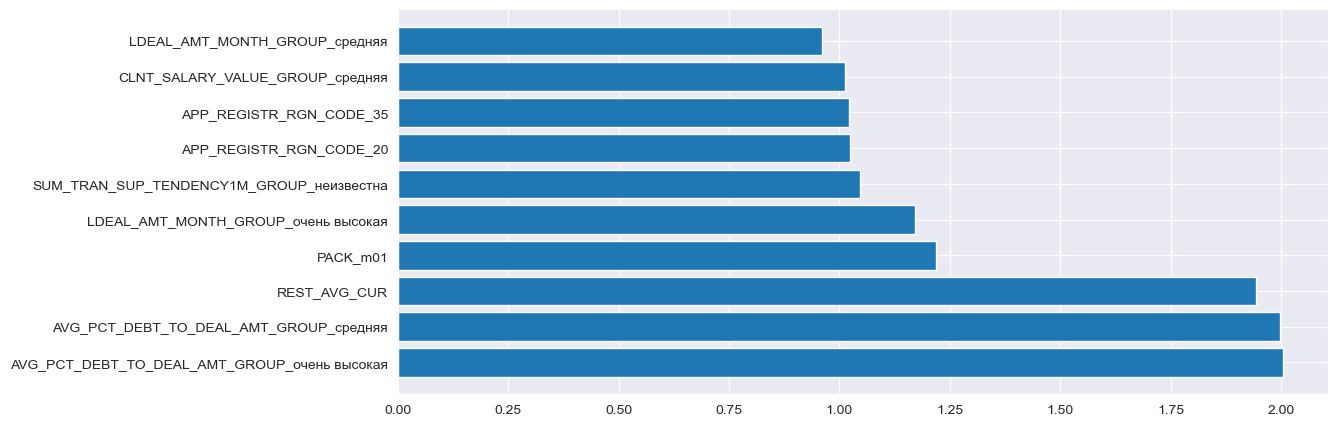

In [35]:
f_importances(abs(clf.coef_[0]), X_train.columns, top=10)